In [1]:
import tensorflow as tf
import pickle
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/V05_SvsS'
mkdir_p(path_tosave)
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DeltaR_min_lep_bjet77", "DRll01","HT_jets","sumPsbtag","met_met","Mll01","DEtall_SS","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [2]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_SvsS.h5', features_to_ignore)

Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 23 features on the dataset 13 features were loaded: 

DPhill_SS
HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DRjj_lead
jet_pt0_nofwd
total_charge
nJets_OR
randomRunNumber
weight_cuu_0p00_cqu1_0p10_cqu8_0p20
weight_cuu_0p04
 


In [3]:
targets = []
sample0, *other = samples
targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
inputs = sample0.data()
targets = np.array(targets, dtype = int )
weights = inputs[:,-1]
inputs = inputs[:,0:-1]
targets = targets[np.where((weights<1) &(weights>0))]
inputs  = inputs[np.where((weights<1) &(weights>0))]
weights = weights[np.where((weights<1) &(weights>0))]
data_len = inputs.shape[0]

In [4]:
weights_cuu = inputs[:,-1]
weights_cqu = inputs[:,-2]
weights_cuu_int = (inputs[:,-1] * 10).astype(int)
weights_cqu_int = (inputs[:,-2] * 10).astype(int)
Number_org = inputs[:,-3]
inputs = inputs[:,0:-3]
feature_names = feature_names[0:-3]
feature_names

['DPhill_SS',
 'HT_lep',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'DeltaR_max_lep_bjet77',
 'DRjj_lead',
 'jet_pt0_nofwd',
 'total_charge',
 'nJets_OR']

In [5]:
reweighted_inputs = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum(),inputs.shape[1]])
targets = np.concatenate([np.zeros(weights_cuu_int.sum()), np.ones(weights_cqu_int.sum())])
Numbers = np.zeros([weights_cuu_int.sum()+weights_cqu_int.sum()])
counter = 0
for i in range(weights_cuu_int.shape[0]):
    for j in range(weights_cuu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        Numbers[counter] = Number_org[i]
        counter +=1
for i in range(weights_cqu_int.shape[0]):
    for j in range(weights_cqu_int[i]):
        reweighted_inputs[counter,:] = inputs[i,:]
        Numbers[counter] = Number_org[i]
        counter +=1        

In [6]:
scaler = StandardScaler().fit(reweighted_inputs)
input_scaled = scaler.transform(reweighted_inputs)

In [7]:
norw_input_scaled = scaler.transform(inputs)

for i in range(input_scaled.shape[1]):
    max_val = input_scaled[:,i].max()
    min_val = input_scaled[:,i].min()
    plt.title(str(feature_names[i]))
    cqu = plt.hist(input_scaled[targets==1], bins=40, range=(min_val, max_val), histtype='step', label='Cqu1+Cqu8', density=True)
    cuu = plt.hist(input_scaled[targets==0], bins=40, range=(min_val, max_val), histtype='step', label='Cuu', density=True)
    plt.hist(norw_input_scaled[:,i], bins=40, histtype='step', linestyle=('dashed'), weights = weights_cuu, density=True, label='Rw-hist Cuu')
    plt.hist(norw_input_scaled[:,i], bins=40, histtype='step', linestyle=('dashed'), weights = weights_cqu, density=True, label='Rw-hist Cqu1+Cqu8')
    plt.legend(frameon=False)
    save_name = path_tosave + "/Input_Feature_" + str(i) + ".png"
    plt.savefig(save_name)
    plt.show()
    if i==3:
        break

In [8]:
def Fold_Odd_Even_changed(input, targets, Number):
    input_odd = input[Number % 2 == 1]
    targets_odd = targets[Number % 2 == 1]
    input_even = input[Number % 2 == 0]
    targets_even = targets[Number % 2 == 0]
    return (input_odd, targets_odd), (input_even, targets_even)

In [9]:
odd, even = Fold_Odd_Even_changed(input_scaled, targets, Numbers)

In [10]:
def Train_Odd_Even_changed(odd, even, n_epochs = 400, batch_size = 2000):
    fit_history_list = []
    model_list = []
    input_shape = odd[0].shape[1]

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

    X_odd, X_val_odd, y_odd, y_val_odd, = train_test_split(odd[0], odd[1], test_size=0.2)
    X_even, X_val_even, y_even, y_val_even, = train_test_split(even[0], even[1], test_size=0.2)

    model_odd = Create_Model_basic(input_shape)
    model_even = Create_Model_basic(input_shape)
    fit_history_odd = model_odd.fit(X_odd, y_odd, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_odd, y_val_odd), verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #
    fit_history_even = model_even.fit(X_even, y_even, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_even, y_val_even), verbose=1 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #

    return fit_history_odd, model_odd, fit_history_even, model_even

In [11]:
input_shape = odd[0].shape[1]
n_epochs = 40
batch_size = 20000

In [12]:
history_odd, model_odd, history_even, model_even= Train_Odd_Even_changed(odd, even, n_epochs = n_epochs, batch_size = batch_size)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9     

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3137983/3137983 [==============================] - 3s 1us/sample - loss: 0.6318 - accuracy: 0.6469 - val_loss: 0.6243 - val_accuracy: 0.6521
Epoch 2/40
3137983/3137983 [==============================] - 2s 1us/sample - loss: 0.6240 - accuracy: 0.6513 - val_loss: 0.6226 - val_accuracy: 0.6529
Epoch 3/40
3137983/3137983 [==============================] - 2s 1us/sample - loss: 0.6228 - accuracy: 0.6519 - val_loss: 0.6220 - val_accuracy: 0.6528
Epoch 4/40
3137983/3137983 [==============================] - 2s 1us/sample - loss: 0.6225 - accuracy: 0.6519 - val_loss: 0.6219 - val_accuracy: 0.6531
Epoch 5/40
3137983/3137983 [==============================] - 2s 1us/sample - loss: 0.6222 - accuracy: 0.6520 - val_loss: 0.6217 - val_accuracy: 0.6531
Epoch 6/40
3137983/3137983 [==============================] - 2s 1us/sample - loss: 0.6218 - accuracy: 0.6523 - val_loss: 0.6212 - val_accuracy: 0.6534
Epoch 7/40
3137983/3137983 [==============================] - 2s 1us/sample - loss: 0.6217 - accura

3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6209 - accuracy: 0.6531 - val_loss: 0.6202 - val_accuracy: 0.6539
Epoch 15/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6209 - accuracy: 0.6531 - val_loss: 0.6199 - val_accuracy: 0.6546
Epoch 16/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6208 - accuracy: 0.6530 - val_loss: 0.6201 - val_accuracy: 0.6548
Epoch 17/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6209 - accuracy: 0.6531 - val_loss: 0.6199 - val_accuracy: 0.6544
Epoch 18/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6206 - accuracy: 0.6532 - val_loss: 0.6200 - val_accuracy: 0.6547
Epoch 19/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6204 - accuracy: 0.6532 - val_loss: 0.6197 - val_accuracy: 0.6549
Epoch 20/40
3030268/3030268 [==============================] - 2s 1us/sample - loss: 0.6204 - 

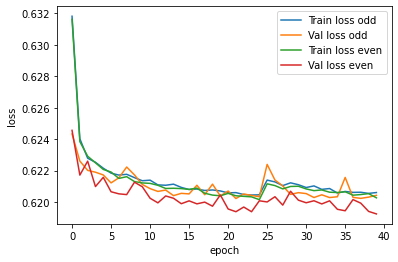

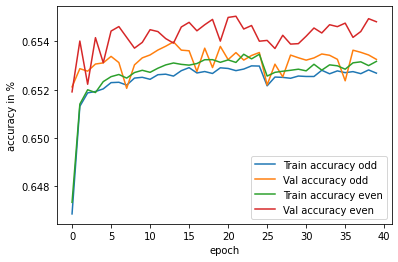

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even.h5


In [13]:
history_list = [history_odd, history_even]
Plot_Metrics_KFold(history_list, path_tosave)
Save_Model(model_odd, path_tosave, "_odd")
Save_Model(model_even, path_tosave, "_even")

In [14]:
model_odd = Load_Model(path_tosave, name="_odd")
model_even = Load_Model(path_tosave, name="_even")
pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even.h5)


In [15]:
def plot_roc_curve_SvS(model,data,path_tosave,odd=True):
    pred = model.predict(data[0])
    truth = data[1]
    fpr, tpr, thr = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = {:.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if odd==True:
        plt.savefig(path_tosave+"/ROC_odd_model.png")
    else:
        plt.savefig(path_tosave+"/ROC_even_model.png")
    plt.show()

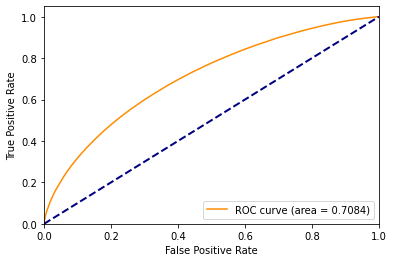

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


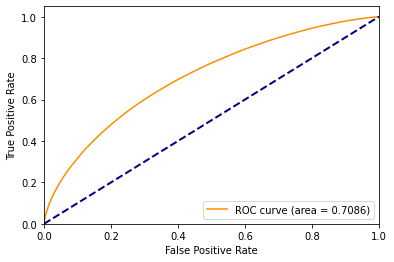

In [16]:
plot_roc_curve_SvS(model_even, odd, path_tosave, odd=False)
plot_roc_curve_SvS(model_odd, even, path_tosave, odd=True)

In [17]:
Predicted_even = model_odd.predict(even[0])
Predicted_odd = model_even.predict(odd[0])

In [18]:
Predicted_Combined = np.squeeze(np.concatenate([Predicted_even, Predicted_odd]))
targets_Combined = np.concatenate([even[1], odd[1]])

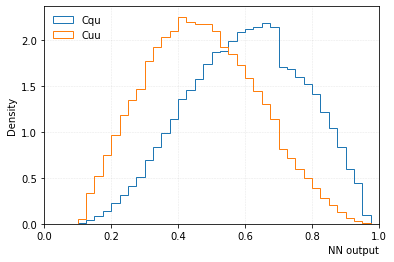

In [19]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(Predicted_Combined[targets_Combined==1],label = "Cqu", **histargs)
plt.hist(Predicted_Combined[targets_Combined==0],label = "Cuu", **histargs)
plt.legend(loc='upper left', frameon=False,)
saveit = "{}/{}".format(path_tosave, "DNN_Output.png")
plt.savefig(saveit)

# Testing with not really reweighted Data

In [20]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_SvsS.h5', features_to_ignore)
targets = []

sample0, *other = samples
targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
inputs = sample0.data()
targets = np.array(targets, dtype = int )
weights = inputs[:,-1]
inputs = inputs[:,0:-1]
targets = targets[np.where((weights<1) &(weights>0))]
inputs  = inputs[np.where((weights<1) &(weights>0))]
weights = weights[np.where((weights<1) &(weights>0))]
data_len = inputs.shape[0]

weights_cuu = inputs[:,-1]
weights_cqu = inputs[:,-2]
weights_cuu_int = (inputs[:,-1] * 10).astype(int)
weights_cqu_int = (inputs[:,-2] * 10).astype(int)
Number_org = inputs[:,-3]
inputs = inputs[:,0:-3]
feature_names = feature_names[0:-3]
feature_names

Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 23 features on the dataset 13 features were loaded: 

DPhill_SS
HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DRjj_lead
jet_pt0_nofwd
total_charge
nJets_OR
randomRunNumber
weight_cuu_0p00_cqu1_0p10_cqu8_0p20
weight_cuu_0p04
 


['DPhill_SS',
 'HT_lep',
 'MtLepMet',
 'jet_pseudoscore_DL1r0',
 'jet_pseudoscore_DL1r1',
 'DeltaR_max_lep_bjet77',
 'DRjj_lead',
 'jet_pt0_nofwd',
 'total_charge',
 'nJets_OR']

In [21]:
inputs_test = scaler.transform(inputs)

In [22]:
Predictions_even = model_odd.predict(inputs_test[Number_org % 2 == 0])
Predictions_odd = model_even.predict(inputs_test[Number_org % 2 == 1])
targets_even = targets[Number_org % 2 == 0]
targets_odd = targets[Number_org % 2 == 1]
weights_cuu_even = weights_cuu[Number_org % 2 == 0]
weights_cuu_odd = weights_cuu[Number_org % 2 == 1]
weights_cqu_even = weights_cqu[Number_org % 2 == 0]
weights_cqu_odd = weights_cqu[Number_org % 2 == 1]

Predictions = np.concatenate([Predictions_even,Predictions_odd])
targets = np.concatenate([targets_even, targets_odd])
weights_cuu = np.concatenate([weights_cuu_even, weights_cuu_odd])
weights_cqu = np.concatenate([weights_cqu_even, weights_cqu_odd])

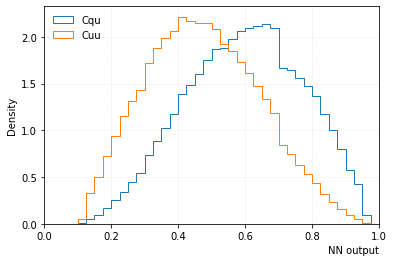

In [23]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(Predictions, label = "Cqu", **histargs, weights=weights_cqu)
plt.hist(Predictions, label = "Cuu", **histargs, weights=weights_cuu)
plt.legend(frameon=False, loc='upper left')
plt.savefig("DNN_Output.png")
plt.show()

# Test on Background

In [24]:
samples, feature_names, class_names, class_no = load_input_file('data/V05_sstt_Data.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 21 features on the dataset 11 features were loaded: 

DPhill_SS
HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DRjj_lead
jet_pt0_nofwd
total_charge
nJets_OR
randomRunNumber
 
Dataset contains extra labels for different backgrounds!
Class 0  :  253953
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Class 9  :  0
Class 10  :  425286
Dataset contains 679239 Signal events and 1425994 Background events.


In [25]:
feature_names = feature_names[:-1]
run_numbers = input_features[:,10]
input_features = input_features[:,0:10]

In [26]:
background_events = input_features[targets==0]
background_run_numbers = run_numbers[targets==0]
background_weights = weights[targets==0]
background_class_labels = class_labels[targets==0]
background_events = scaler.transform(background_events)
odd_background, even_background = Fold_Odd_Even(background_events, targets[targets==0], background_weights, background_class_labels, background_run_numbers)

In [27]:
signal_events = input_features[targets==1]
signal_run_numbers = run_numbers[targets==1]
signal_weights = weights[targets==1]
signal_class_labels = class_labels[targets==1]
signal_events = scaler.transform(signal_events)
odd_signal, even_signal = Fold_Odd_Even(signal_events, targets[targets==1], signal_weights, signal_class_labels, signal_run_numbers)

In [28]:
Predict_bkg_odd = model_even.predict(odd_background[0])
Predict_bkg_even = model_odd.predict(even_background[0])
Predict_sig_odd = model_even.predict(odd_signal[0])
Predict_sig_even = model_odd.predict(even_signal[0])

Predicted_Background = np.concatenate([Predict_bkg_odd, Predict_bkg_even])
Predicted_Signal = np.concatenate([Predict_sig_odd, Predict_sig_even])

In [29]:
def Find_Eff_Cut_Equal(Sig, Bkg):
    steps = 1000
    Cut = np.linspace(0,1,steps)
    Sig_Eff_list = []
    Bkg_Eff_list = []
    for i in range(steps):    
        Sig_Eff_list.append(Sig[Sig > Cut[i]].size/Sig.size)
        Bkg_Eff_list.append(Bkg[Bkg < Cut[i]].size/Bkg.size)
    Sig_Eff_list = np.array(Sig_Eff_list)
    Bkg_Eff_list = np.array(Bkg_Eff_list)
    best_step = np.argmax(Sig_Eff_list + Bkg_Eff_list)
    
    print(f"Cut_Value: {Cut[best_step]:.3f}")
    print(f"Sig_Eff: {Sig_Eff_list[best_step]:.3f}")
    print(f"Bkg_Eff: {Bkg_Eff_list[best_step]:.3f}")
    
    return Sig_Eff_list[best_step], Bkg_Eff_list[best_step], Cut[best_step]

Sig = Predicted_Combined[targets_Combined==1]
Bkg = Predicted_Combined[targets_Combined==0]
Sig_Eff, Bkg_Eff, Signal_Cut = Find_Eff_Cut_Equal(Sig=Sig, Bkg=Bkg)

Cut_Value: 0.541
Sig_Eff: 0.638
Bkg_Eff: 0.663


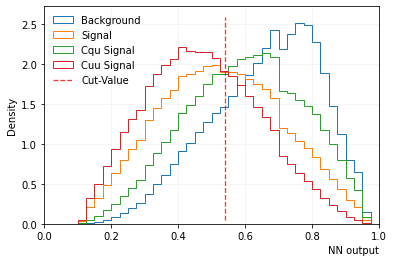

In [30]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(Predicted_Background, label = "Background", **histargs)
plt.hist(Predicted_Signal, label="Signal", **histargs)
plt.hist(Predictions, label = "Cqu Signal", **histargs, weights=weights_cqu)
plt.hist(Predictions, label = "Cuu Signal", **histargs, weights=weights_cuu)
plt.vlines(Signal_Cut, ymin=plt.gca().get_ylim()[0]+ plt.gca().get_ylim()[1]*0.02, ymax=plt.gca().get_ylim()[1]*0.98, color='red', linestyle='--', label='Cut-Value', alpha=0.8, linewidth=1.3)

plt.legend(frameon=False, loc='upper left')
plt.show()

# Feature Importance

f, g = get_feature_importance(odd, model_even, Signal_Cut, 2)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(odd[0].shape[1]), np.sort(f), color="r", alpha=0.7)
ax.set_yticks(range(odd[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_tosave + "/Feature_Importance.png")

# Split into Cuu SR & Cqu SR

In [31]:
def Split_in_SR(input_data, Predict, Signal_Cut):
    mask_cuu = np.squeeze(Predict < Signal_Cut)
    mask_cqu = np.squeeze(Predict >= Signal_Cut)
    features_cuu = input_data[0][mask_cuu,:]
    features_cqu = input_data[0][mask_cqu,:]
    targets_cuu = input_data[1][mask_cuu]
    targets_cqu = input_data[1][mask_cqu]
    weights_cuu = input_data[2][mask_cuu]
    weights_cqu = input_data[2][mask_cqu]
    class_labels_cuu = input_data[3][mask_cuu]
    class_labels_cqu = input_data[3][mask_cqu]
    cuu = (features_cuu, targets_cuu, weights_cuu, class_labels_cuu)
    cqu = (features_cqu, targets_cqu, weights_cqu, class_labels_cqu)
    return cuu, cqu

In [32]:
odd_background_cuu, odd_background_cqu = Split_in_SR(odd_background, Predict_bkg_odd, Signal_Cut=Signal_Cut)
even_background_cuu, even_background_cqu = Split_in_SR(even_background, Predict_bkg_even, Signal_Cut=Signal_Cut)
odd_signal_cuu, odd_signal_cqu = Split_in_SR(odd_signal, Predict_sig_odd, Signal_Cut=Signal_Cut)
even_signal_cuu, even_signal_cqu = Split_in_SR(even_signal, Predict_sig_even, Signal_Cut=Signal_Cut)

In [33]:
def Combine_Signal_Background(Sig, Bkg):
    a0 = np.concatenate([Sig[0],Bkg[0]])
    a1 = np.concatenate([Sig[1],Bkg[1]])
    a2 = np.concatenate([Sig[2],Bkg[2]])
    a3 = np.concatenate([Sig[3],Bkg[3]])
    return (a0, a1, a2, a3)

In [34]:
odd_cuu = Combine_Signal_Background(odd_signal_cuu, odd_background_cuu)
even_cuu = Combine_Signal_Background(even_signal_cuu, even_background_cuu)
odd_cqu = Combine_Signal_Background(odd_signal_cqu, odd_background_cqu)
even_cqu = Combine_Signal_Background(even_signal_cqu, even_background_cqu)

In [35]:
ScaleWeights(odd_cuu[1],odd_cuu[2])
ScaleWeights(even_cuu[1],even_cuu[2])
ScaleWeights(odd_cqu[1],odd_cqu[2])
ScaleWeights(even_cqu[1],even_cqu[2])


======Weight Statistic========================================
Weights::        W(1)=258.058, W(0)=365.833
Scaled weights:: W(1)=172063, W(0)=172063

======Weight Statistic========================================
Weights::        W(1)=273.284, W(0)=402.217
Scaled weights:: W(1)=179604, W(0)=179604

======Weight Statistic========================================
Weights::        W(1)=348.102, W(0)=1135.21
Scaled weights:: W(1)=363716, W(0)=363716

======Weight Statistic========================================
Weights::        W(1)=321.033, W(0)=1080.42
Scaled weights:: W(1)=337234, W(0)=337234


# Train SvsB NN

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


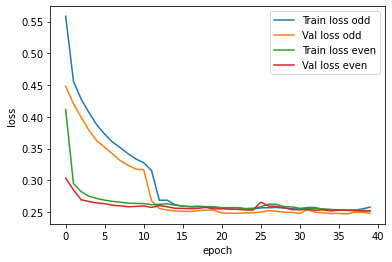

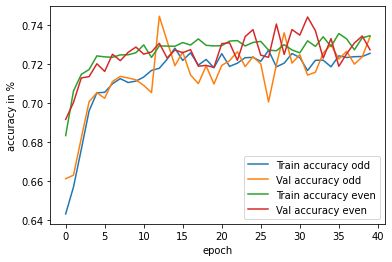

In [36]:
hist_cuu_odd, model_cuu_odd, hist_cuu_even, model_cuu_even = Train_Odd_Even(odd_cuu, even_cuu, n_epochs = n_epochs, batch_size = batch_size)
history_list_cuu = [hist_cuu_odd, hist_cuu_even]
Plot_Metrics_KFold(history_list_cuu, path_tosave)

In [37]:
Save_Model(model_cuu_odd, path_tosave, "_odd_cuu")
Save_Model(model_cuu_even, path_tosave, "_even_cuu")

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cuu.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cuu.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cuu.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cuu.h5


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_28 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9   

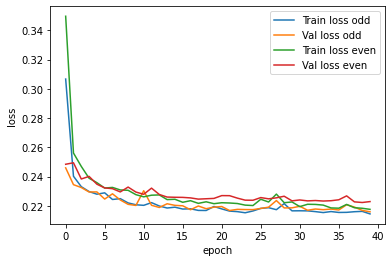

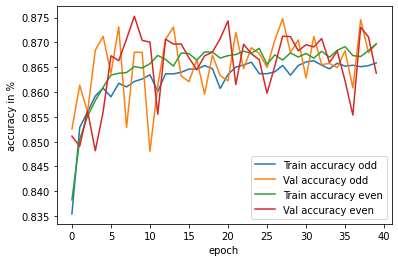

In [38]:
hist_cqu_odd, model_cqu_odd, hist_cqu_even, model_cqu_even = Train_Odd_Even(odd_cqu, even_cqu, n_epochs = n_epochs, batch_size = batch_size)
history_list_cqu = [hist_cqu_odd, hist_cqu_even]
Plot_Metrics_KFold(history_list_cqu, path_tosave)

In [39]:
Save_Model(model_cqu_odd, path_tosave, "_odd_cqu")
Save_Model(model_cqu_even, path_tosave, "_even_cqu")

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cqu.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cqu.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cqu.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cqu.h5


In [40]:
model_cuu_even = Load_Model(path_tosave, name="_even_cuu")
model_cuu_odd = Load_Model(path_tosave, name="_odd_cuu")
model_cqu_even = Load_Model(path_tosave, name="_even_cqu")
model_cqu_odd = Load_Model(path_tosave, name="_odd_cqu")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cuu.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cuu.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cuu.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cuu.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_even_cqu.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_even_cqu.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/architecture_odd_cqu.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_SvsS/weights_odd_cqu.h5)


In [41]:
pred1 = model_cuu_odd.predict(even_cuu[0])
pred2 = model_cuu_even.predict(odd_cuu[0])
pred3 = model_cqu_odd.predict(even_cqu[0])
pred4 = model_cqu_even.predict(odd_cqu[0])

truth1 = even_cuu[1]
truth2 = odd_cuu[1]
truth3 = even_cqu[1]
truth4 = odd_cqu[1]

weights1 = even_cuu[2]
weights2 = odd_cuu[2]
weights3 = even_cqu[2]
weights4 = odd_cqu[2]

pred = np.concatenate([pred1, pred2, pred3, pred4])
truth = np.concatenate([truth1, truth2, truth3, truth4])
weights = np.concatenate([weights1, weights2, weights3, weights4])

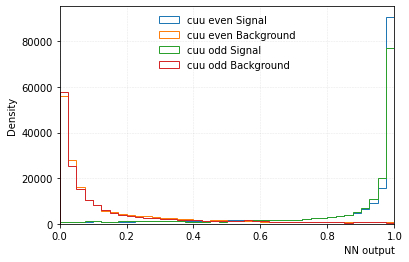

In [58]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred1[:,0][truth1==1],label = "cuu even Signal", **histargs, weights=weights1[truth1==1])
plt.hist(pred1[:,0][truth1==0],label = "cuu even Background", **histargs, weights=weights1[truth1==0])
plt.hist(pred2[:,0][truth2==1],label = "cuu odd Signal", **histargs, weights=weights2[truth2==1])
plt.hist(pred2[:,0][truth2==0],label = "cuu odd Background", **histargs, weights=weights2[truth2==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

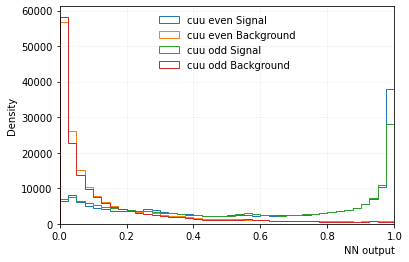

In [61]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred1[:,0][truth1==1],label = "cuu even Signal", **histargs)
plt.hist(pred1[:,0][truth1==0],label = "cuu even Background", **histargs)
plt.hist(pred2[:,0][truth2==1],label = "cuu odd Signal", **histargs)
plt.hist(pred2[:,0][truth2==0],label = "cuu odd Background", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.show()

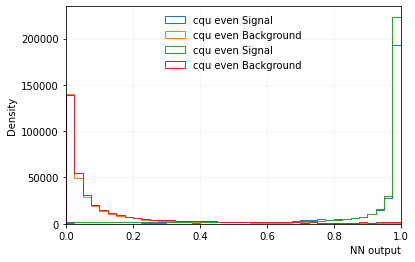

In [59]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred3[:,0][truth3==1],label = "cqu even Signal", **histargs, weights=weights3[truth3==1])
plt.hist(pred3[:,0][truth3==0],label = "cqu even Background", **histargs, weights=weights3[truth3==0])
plt.hist(pred4[:,0][truth4==1],label = "cqu even Signal", **histargs, weights=weights4[truth4==1])
plt.hist(pred4[:,0][truth4==0],label = "cqu even Background", **histargs, weights=weights4[truth4==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

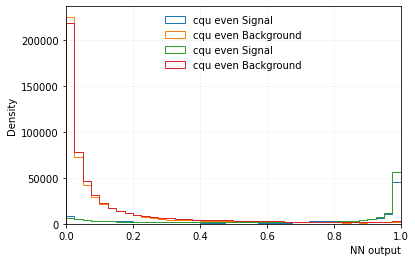

In [60]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred3[:,0][truth3==1],label = "cqu even Signal", **histargs)
plt.hist(pred3[:,0][truth3==0],label = "cqu even Background", **histargs)
plt.hist(pred4[:,0][truth4==1],label = "cqu even Signal", **histargs)
plt.hist(pred4[:,0][truth4==0],label = "cqu even Background", **histargs)
plt.legend(loc='upper center', frameon=False)
plt.show()

In [43]:
fpr1, tpr1, thr1 = roc_curve(truth1, pred1, sample_weight=weights1)
fpr2, tpr2, thr2 = roc_curve(truth2, pred2, sample_weight=weights2)
fpr3, tpr3, thr3 = roc_curve(truth3, pred3, sample_weight=weights3)
fpr4, tpr4, thr4 = roc_curve(truth4, pred4, sample_weight=weights4)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

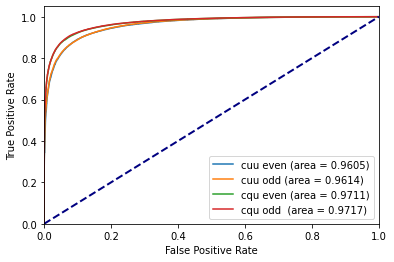

In [45]:
plt.plot(fpr1, tpr1 ,label='cuu even (area = {:.4f})'.format(roc_auc1))
plt.plot(fpr2, tpr2 ,label='cuu odd (area = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3 ,label='cqu even (area = {:.4f})'.format(roc_auc3))
plt.plot(fpr4, tpr4 ,label='cqu odd  (area = {:.4f})'.format(roc_auc4))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

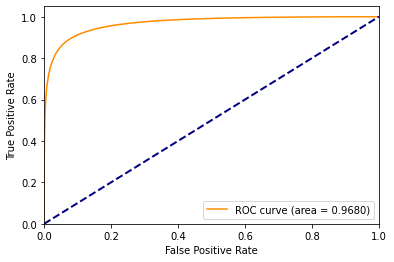

In [42]:
fpr, tpr, thr = roc_curve(truth, pred, sample_weight=weights)
roc_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()